<a href="https://colab.research.google.com/github/MatveyOreshkinn/abalone_regression/blob/eda/eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA

In [139]:
from google.colab import drive
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV


warnings.filterwarnings("ignore")
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Загрузка [датасета](https://archive.ics.uci.edu/dataset/1/abalone)       

+1,5 к Rings дает возраст в годах

In [96]:
df = pd.read_csv('/content/drive/MyDrive/abalone_regression/abalone.csv')
df['Rings'] += 1.5

df.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,16.5
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,8.5
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,10.5
3,M,0.440,0.365,0.125,NaN,0.2155,0.1140,0.155,11.5
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,8.5


In [97]:
df.shape

(4177, 9)

Есть пропущенные значения в трёх колонках: Diameter, Whole weight, Shell weight.

In [98]:
df.isna().mean()

,0
Sex,0.000000
Length,0.000000
Diameter,0.023701
Height,0.000000
Whole weight,0.023701
Shucked weight,0.000000
Viscera weight,0.000000
Shell weight,0.011970
Rings,0.000000


В будущем для обучение модели категориальная колонка Sex может помешать, поэтому применим к ней one-hot кодирование

In [99]:
df = pd.get_dummies(data=df, columns=['Sex'], dtype=np.int8)

df

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Sex_F,Sex_I,Sex_M,Sex_f
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,16.5,0,0,1,0
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,8.5,0,0,1,0
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,10.5,1,0,0,0
3,0.440,0.365,0.125,NaN,0.2155,0.1140,0.1550,11.5,0,0,1,0
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,8.5,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4172,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,12.5,1,0,0,0
4173,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,11.5,0,0,1,0
4174,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,10.5,0,0,1,0
4175,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,11.5,1,0,0,0


В колонке Sex ошибочно иногда встречается f

In [100]:
df['Sex_F'] = (df['Sex_f'] | df['Sex_F']).astype(int)


df.drop('Sex_f', axis=1, inplace=True)

Посмотрим влияние каждого признака на целевую переменную:

In [101]:
grouped_data = df.groupby('Length')['Rings'].mean()
grouped_data

,Rings
Length,
0.075,2.5
0.110,4.5
0.130,5.0
0.135,5.5
0.140,5.0
...,...
0.770,12.5
0.775,16.0
0.780,12.5


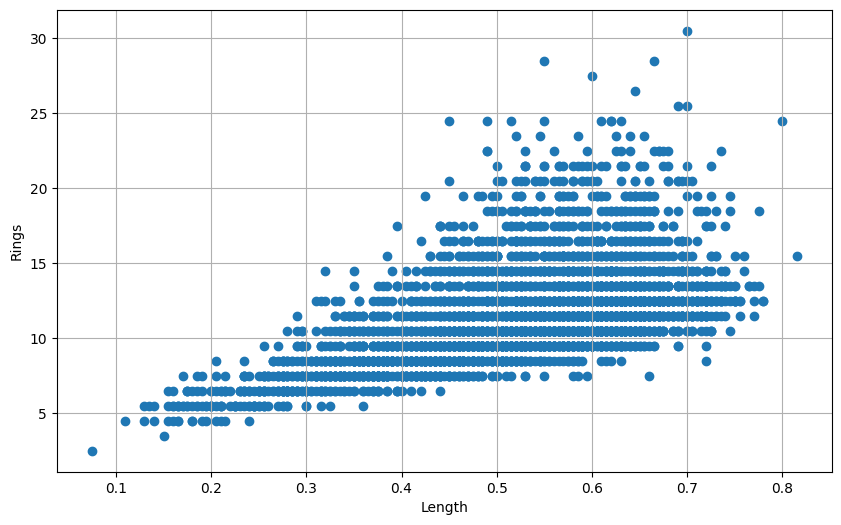

In [102]:

plt.figure(figsize=(10, 6))
plt.scatter(df['Length'], df['Rings'])

plt.xlabel('Length')
plt.ylabel('Rings')
plt.grid()
plt.show()

При увеличении длины - увеличивается и возраст

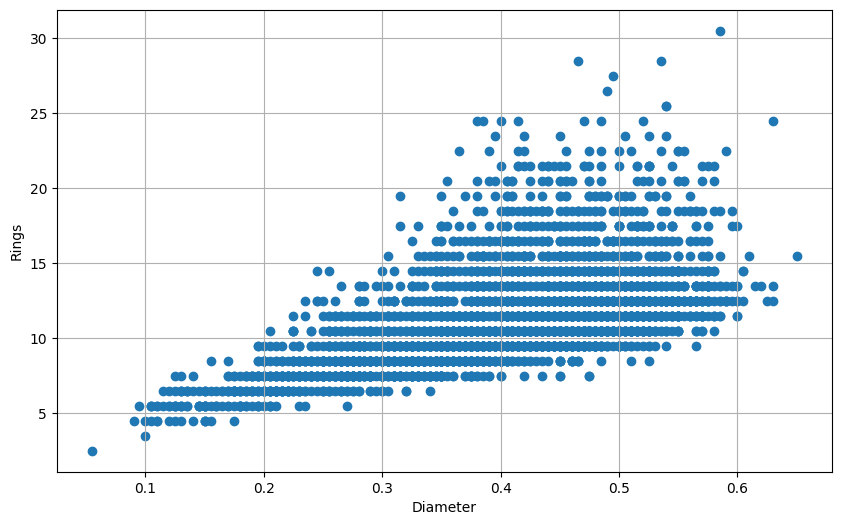

In [103]:

plt.figure(figsize=(10, 6))
plt.scatter(df['Diameter'], df['Rings'])

plt.xlabel('Diameter')
plt.ylabel('Rings')
plt.grid()
plt.show()

Диаметр имеет такое же распределение как и длина. Это значит, что увеличение длины и диаметра происходит одинаково, пропорционально возрасту.

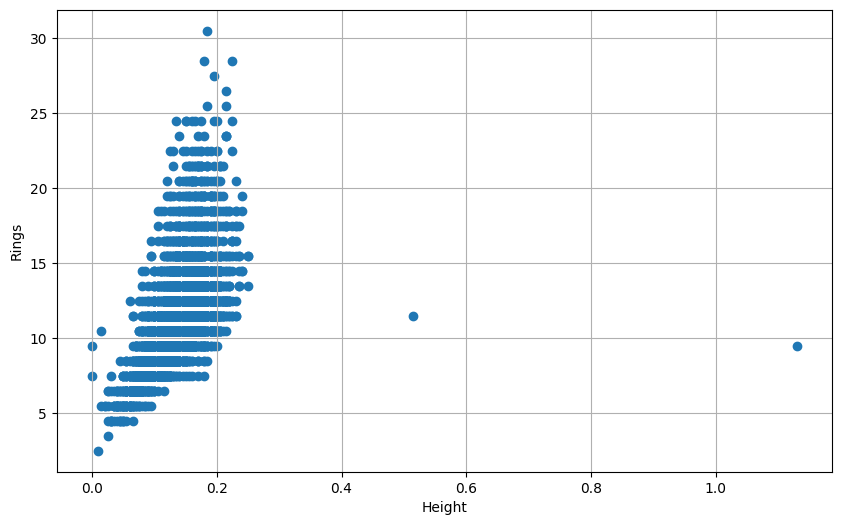

In [104]:
plt.figure(figsize=(10, 6))
plt.scatter(df['Height'], df['Rings'])

plt.xlabel('Height')
plt.ylabel('Rings')
plt.grid()
plt.show()

При увеличении высоты - возраст становится больше, есть 2 аномальных значения, удалим их.

In [105]:
df.drop(df[df['Height'] > 0.4].index, inplace=True, axis=0)

df[df['Height'] > 0.4]

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Sex_F,Sex_I,Sex_M


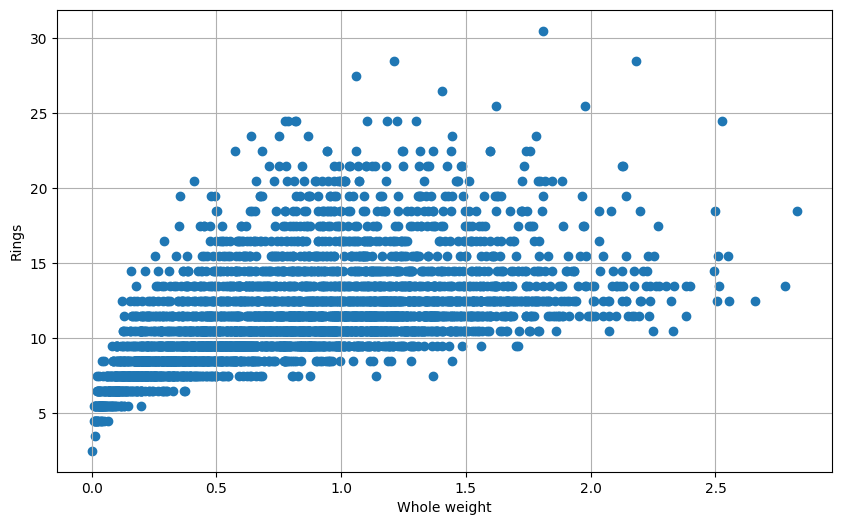

In [106]:
plt.figure(figsize=(10, 6))
plt.scatter(df['Whole weight'], df['Rings'])

plt.xlabel('Whole weight')
plt.ylabel('Rings')
plt.grid()
plt.show()

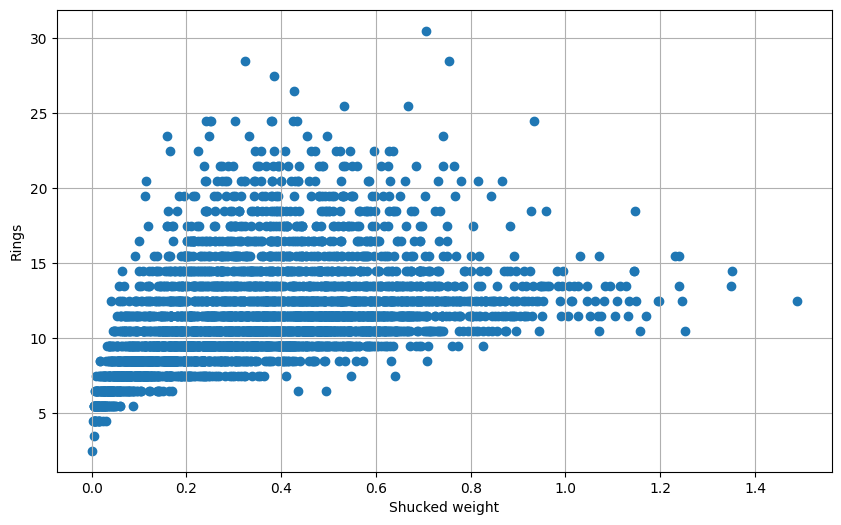

In [107]:
plt.figure(figsize=(10, 6))
plt.scatter(df['Shucked weight'], df['Rings'])

plt.xlabel('Shucked weight')
plt.ylabel('Rings')
plt.grid()
plt.show()

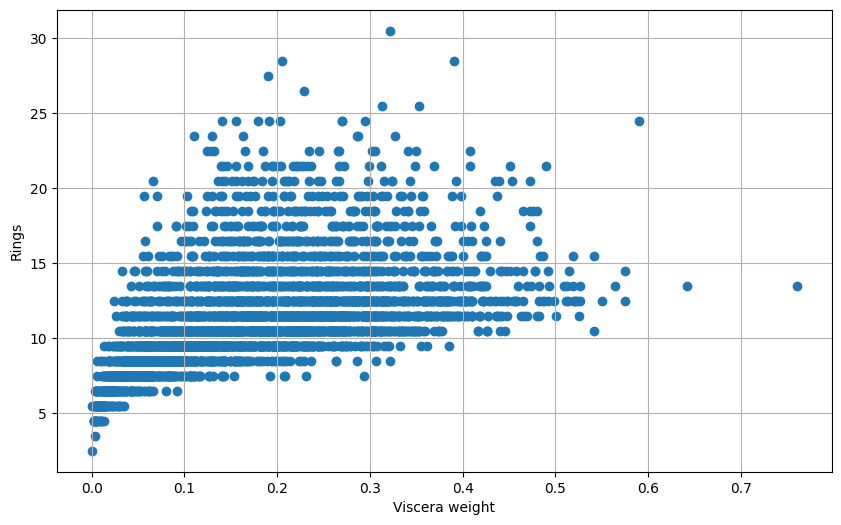

In [108]:
plt.figure(figsize=(10, 6))
plt.scatter(df['Viscera weight'], df['Rings'])

plt.xlabel('Viscera weight')
plt.ylabel('Rings')
plt.grid()
plt.show()

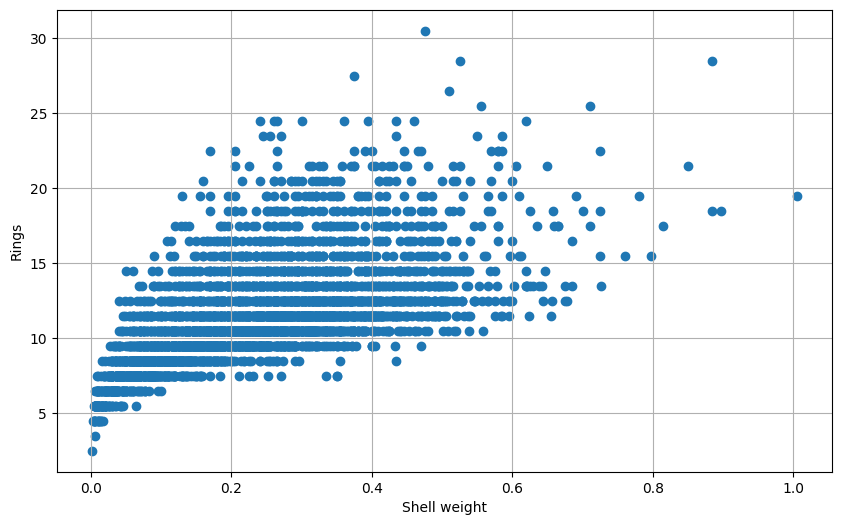

In [109]:
plt.figure(figsize=(10, 6))
plt.scatter(df['Shell weight'], df['Rings'])

plt.xlabel('Shell weight')
plt.ylabel('Rings')
plt.grid()
plt.show()

Whole weight, Shell weight, Viscera weight, Shucked weight одинаково распределены, распределение напоминет график корня.

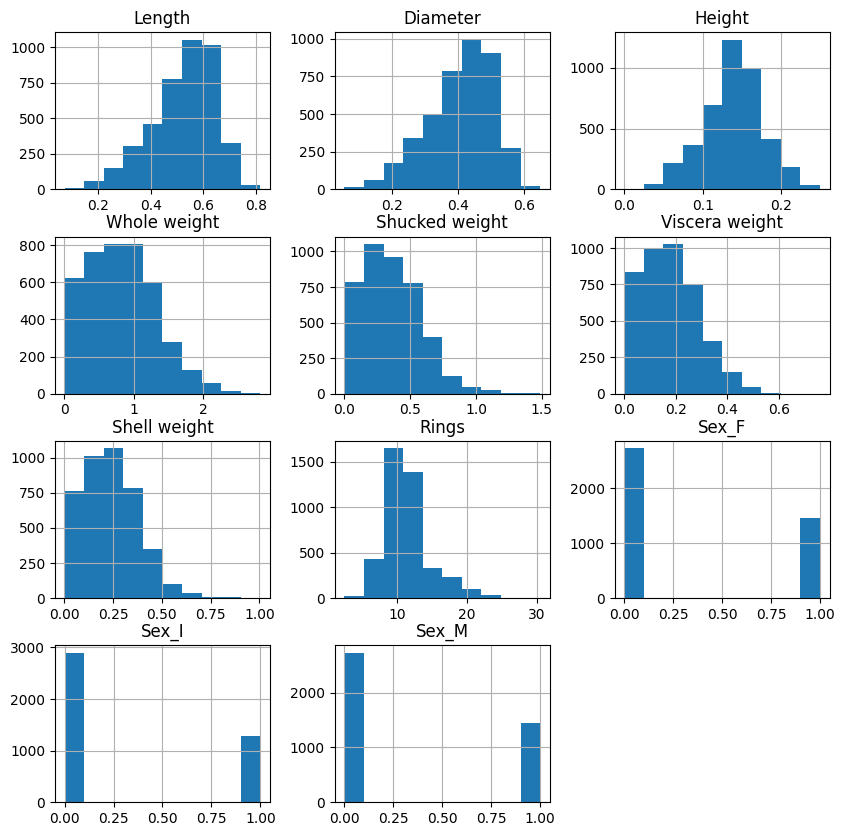

In [110]:
df.hist(figsize=(10, 10))
plt.show()

Распределение целевой переменной напоминает log-нормальное распределение.

Построим матрицу корреляций:

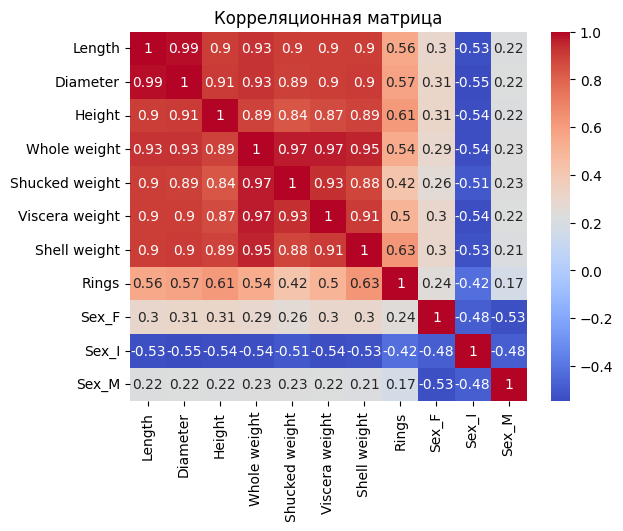

In [111]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()

В будущем из-за использования метрических алгоритмов для заполнения пропусков и предсказания возраста нормализуем данные.

In [112]:
scaler = RobustScaler()

scaled_data = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_data, columns=df.columns, index=df.index)

scaled_df

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Sex_F,Sex_I,Sex_M
0,-0.545455,-0.461538,-0.9,-0.400563,-0.353127,-0.438871,-0.429293,2.000000,0.0,0.0,1.0
1,-1.181818,-1.230769,-1.0,-0.806758,-0.749010,-0.768025,-0.833333,-0.666667,0.0,0.0,1.0
2,-0.090909,-0.038462,-0.1,-0.171067,-0.251781,-0.184953,-0.126263,0.000000,1.0,0.0,0.0
3,-0.636364,-0.461538,-0.3,NaN,-0.381631,-0.357367,-0.404040,0.333333,0.0,0.0,1.0
4,-1.303030,-1.307692,-1.2,-0.835621,-0.780681,-0.824451,-0.909091,-0.666667,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
4172,0.121212,0.192308,0.5,0.124604,0.107680,0.426332,0.070707,0.666667,1.0,0.0,0.0
4173,0.272727,0.115385,-0.1,0.235832,0.326207,0.272727,0.128788,0.333333,0.0,0.0,1.0
4174,0.333333,0.384615,1.3,0.531503,0.600158,0.730408,0.368687,0.000000,0.0,0.0,1.0
4175,0.484848,0.461538,0.2,0.416755,0.617577,0.564263,0.308081,0.333333,1.0,0.0,0.0


С помощью поиска по сетке подберем лучшие параметры для KNNImputer и заполним пропуски.

In [113]:
imputer = KNNImputer()
param_grid = {'n_neighbors': range(2, 11),
              'weights': ['uniform', 'distance']}

grid_search = GridSearchCV(imputer, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(scaled_df)

best_imputer = grid_search.best_estimator_

imputed_arr = best_imputer.transform(scaled_df)
df_filled = pd.DataFrame(imputed_arr, columns=df.columns, index=df.index)

df_filled

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Sex_F,Sex_I,Sex_M
0,-0.545455,-0.461538,-0.9,-0.400563,-0.353127,-0.438871,-0.429293,2.000000,0.0,0.0,1.0
1,-1.181818,-1.230769,-1.0,-0.806758,-0.749010,-0.768025,-0.833333,-0.666667,0.0,0.0,1.0
2,-0.090909,-0.038462,-0.1,-0.171067,-0.251781,-0.184953,-0.126263,0.000000,1.0,0.0,0.0
3,-0.636364,-0.461538,-0.3,-0.432946,-0.381631,-0.357367,-0.404040,0.333333,0.0,0.0,1.0
4,-1.303030,-1.307692,-1.2,-0.835621,-0.780681,-0.824451,-0.909091,-0.666667,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
4172,0.121212,0.192308,0.5,0.124604,0.107680,0.426332,0.070707,0.666667,1.0,0.0,0.0
4173,0.272727,0.115385,-0.1,0.235832,0.326207,0.272727,0.128788,0.333333,0.0,0.0,1.0
4174,0.333333,0.384615,1.3,0.531503,0.600158,0.730408,0.368687,0.000000,0.0,0.0,1.0
4175,0.484848,0.461538,0.2,0.416755,0.617577,0.564263,0.308081,0.333333,1.0,0.0,0.0


Дубликатов в данных нет

In [114]:
df_filled[df_filled.duplicated()]

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Sex_F,Sex_I,Sex_M


Сохраним обработанные данные

In [120]:
df_filled.to_csv('abalone_preprocessed.csv', index=False)

# Вопросы

1) В каком порядке выполнять: удаление дубликатов, масштабирование, заполнение пропусков, поиск аномалий в данных, однофакторный анализ, кодирование.                  
2) Корреляция спопобна улавливать только линейную зависимость. Так ли она тогда полезна? Как определить какие параметры использовать обучения для модели?                
3) Как поиск по сетке находит лучшую модель для KNNImputer, если ему особо не с чем сравнивать точность моделей?

## Polars

Создадим большой датасет

In [118]:
df_big = df.copy()

for _ in range(200):
    df_big = pd.concat([df_big, df], ignore_index=True)

df_big.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Sex_F,Sex_I,Sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,16.5,0,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,8.5,0,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,10.5,1,0,0
3,0.440,0.365,0.125,NaN,0.2155,0.1140,0.155,11.5,0,0,1
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,8.5,0,1,0


In [119]:
df.shape, df_big.shape

((4175, 11), (839175, 11))

In [121]:
df_big.to_csv('abalone_big.csv', index=False)


In [126]:
%%time

df = pd.read_csv('abalone_big.csv')

CPU times: user 1.08 s, sys: 79.3 ms, total: 1.16 s
Wall time: 1.2 s


In [127]:
%%time

df_pl = pl.read_csv('abalone_big.csv')

CPU times: user 603 ms, sys: 6.42 ms, total: 609 ms
Wall time: 443 ms


Polaris быстрее считал данные

In [130]:
%%time

df_pl[['Rings', 'Length']]

CPU times: user 243 µs, sys: 29 µs, total: 272 µs
Wall time: 279 µs


Rings,Length
f64,f64
16.5,0.455
8.5,0.35
10.5,0.53
11.5,0.44
8.5,0.33
…,…
12.5,0.565
11.5,0.59
10.5,0.6


In [131]:
%%time

df[['Rings', 'Length']]

CPU times: user 5.61 ms, sys: 1.92 ms, total: 7.53 ms
Wall time: 10.6 ms


,Rings,Length
0,16.5,0.455
1,8.5,0.350
2,10.5,0.530
3,11.5,0.440
4,8.5,0.330
...,...,...
839170,12.5,0.565
839171,11.5,0.590
839172,10.5,0.600
839173,11.5,0.625


Polaris быстрее сгрупировал данные

In [137]:
%%time

df.groupby('Length')['Rings'].mean()

CPU times: user 26.6 ms, sys: 0 ns, total: 26.6 ms
Wall time: 26 ms


,Rings
Length,
0.075,2.5
0.110,4.5
0.130,5.0
0.135,5.5
0.140,5.0
...,...
0.770,12.5
0.775,16.0
0.780,12.5


In [138]:
%%time

df_pl.group_by('Length').agg(pl.col('Rings').mean())

CPU times: user 74.7 ms, sys: 0 ns, total: 74.7 ms
Wall time: 60.3 ms


Length,Rings
f64,f64
0.61,12.566667
0.475,10.438462
0.53,12.212329
0.47,10.683333
0.405,9.26
…,…
0.625,12.37234
0.14,5.0
0.505,11.431034


Pandas быстрее агрегирует данные.